# **Importing the libraries**

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

2025-07-02 19:36:56.907710: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751485017.370423      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751485017.481656      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# **Loading and Splitting the dataset**

In [2]:
(raw_train_ds, raw_val_ds), ds_info = tfds.load(
    'oxford_iiit_pet',
    split=['train', 'test'],
    as_supervised=True,
    with_info=True
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

I0000 00:00:1751485094.500173      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1751485094.500920      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.R37B2R_4.0.0/oxford_iiit_pet-train.tfrecord*...…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.R37B2R_4.0.0/oxford_iiit_pet-test.tfrecord*...:…

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/4.0.0. Subsequent calls will reuse this data.


# **Constructing the data pipeline**

In [3]:
IMG_SIZE = 224
BATCH_SIZE = 32

preprocess_input = tf.keras.applications.resnet50.preprocess_input

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

def format_example(image, label):
    image = tf.image.resize(image, (224, 224))
    image = data_augmentation(image)
    image = tf.keras.applications.resnet50.preprocess_input(image)
    return image, label

train_ds = (
    raw_train_ds
    .map(format_example, num_parallel_calls=tf.data.AUTOTUNE)
    .cache()
    .shuffle(1000)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

val_ds = (
    raw_val_ds
    .map(format_example, num_parallel_calls=tf.data.AUTOTUNE)
    .cache()
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

# **Building the model using ResNet50**

In [4]:
base_model = tf.keras.applications.ResNet50(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = True

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(
        512,
        activation='relu',
        kernel_regularizer=tf.keras.regularizers.l2(0.001)  # ✅ using tf
    ),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(37, activation='softmax')
])


model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),  # Use a low learning rate!
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# **Training the model**

In [5]:
history = model.fit(train_ds, validation_data=val_ds, epochs=30)

Epoch 1/30


I0000 00:00:1751485212.589595     121 service.cc:148] XLA service 0x7fcc8420ab80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751485212.592681     121 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1751485212.592705     121 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1751485217.398824     121 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1751485239.371087     121 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


115/115 ━━━━━━━━━━━━━━━━━━━━ 160s 690ms/step - accuracy: 0.0426 - loss: 4.9299 - val_accuracy: 0.2289 - val_loss: 3.8447
Epoch 2/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 40s 347ms/step - accuracy: 0.1889 - loss: 3.8187 - val_accuracy: 0.5944 - val_loss: 2.7393
Epoch 3/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 41s 353ms/step - accuracy: 0.4770 - loss: 2.8782 - val_accuracy: 0.7419 - val_loss: 1.9774
Epoch 4/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 41s 358ms/step - accuracy: 0.6663 - loss: 2.1748 - val_accuracy: 0.8054 - val_loss: 1.6582
Epoch 5/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 42s 364ms/step - accuracy: 0.8038 - loss: 1.7188 - val_accuracy: 0.8310 - val_loss: 1.5061
Epoch 6/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 42s 366ms/step - accuracy: 0.8614 - loss: 1.4418 - val_accuracy: 0.8441 - val_loss: 1.4250
Epoch 7/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 42s 367ms/step - accuracy: 0.9004 - loss: 1.2729 - val_accuracy: 0.8504 - val_loss: 1.3741
Epoch 8/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9199 - loss: 1.1807 - va

# **Visualizing the Model's Training History**

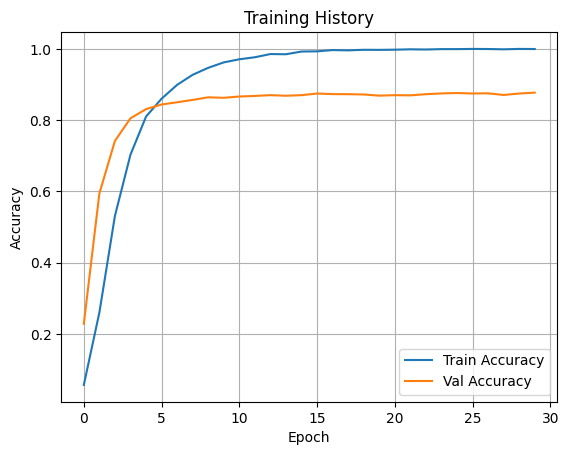

In [6]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.title('Training History')
plt.show()

# **Evaluating the model using Confusion Matrix and Classification Report**

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms

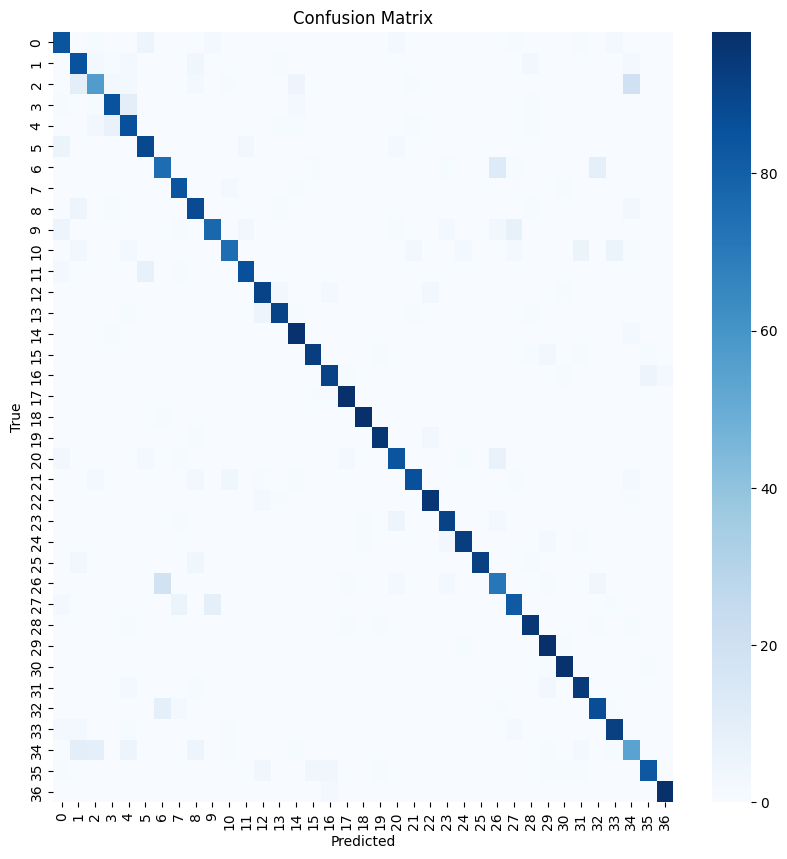

              precision    recall  f1-score   support

           0       0.79      0.86      0.82        98
           1       0.72      0.85      0.78       100
           2       0.76      0.57      0.65       100
           3       0.88      0.85      0.86       100
           4       0.77      0.86      0.81       100
           5       0.86      0.89      0.87       100
           6       0.72      0.75      0.74       100
           7       0.88      0.95      0.91        88
           8       0.81      0.89      0.85        99
           9       0.88      0.77      0.82       100
          10       0.89      0.75      0.82       100
          11       0.93      0.89      0.91        97
          12       0.88      0.91      0.90       100
          13       0.93      0.91      0.92       100
          14       0.89      0.97      0.93       100
          15       0.94      0.93      0.93       100
          16       0.91      0.91      0.91       100
          17       0.95    

In [7]:
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, cmap="Blues", xticklabels=range(37), yticklabels=range(37))
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print(classification_report(y_true, y_pred))

# **Visualizing Model Predictions**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


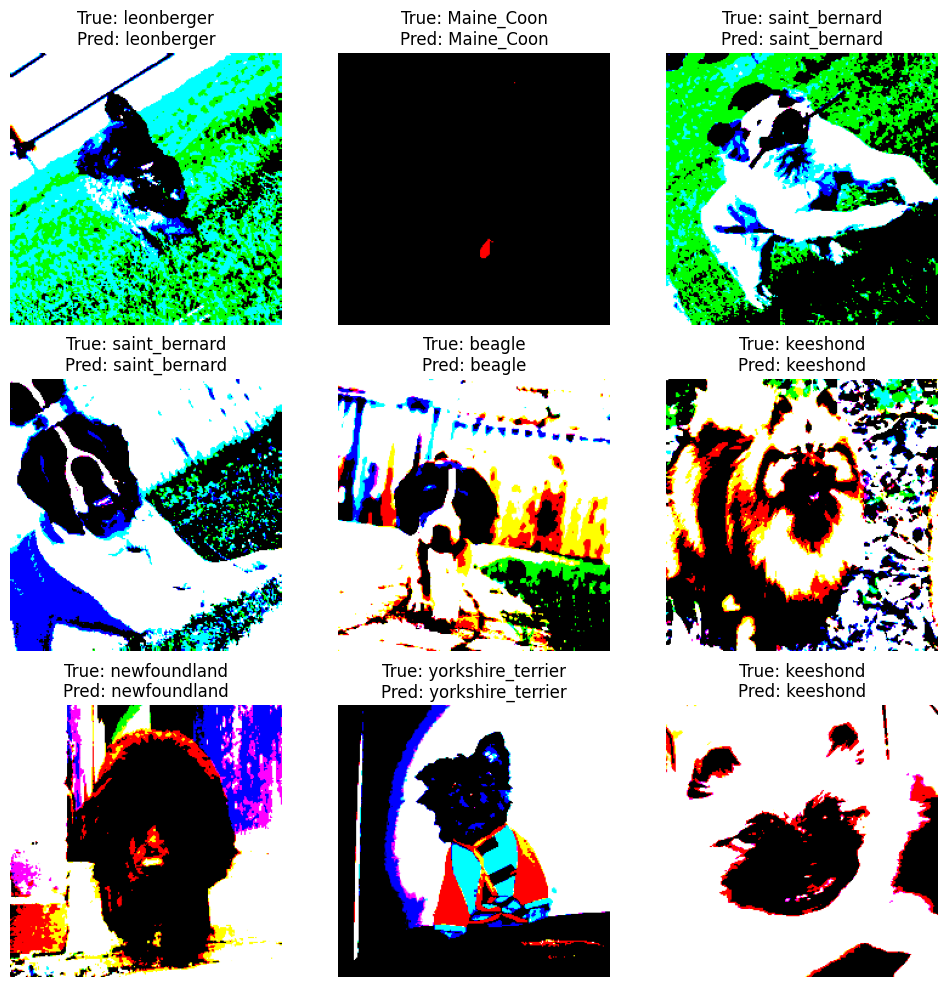

In [8]:
class_names = ds_info.features['label'].names
for images, labels in val_ds.take(1):
    preds = model.predict(images)
    pred_labels = tf.argmax(preds, axis=1)
    plt.figure(figsize=(12, 12))
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i])
        plt.title(f"True: {class_names[labels[i]]}\nPred: {class_names[pred_labels[i]]}")
        plt.axis("off")
    plt.show()